# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [4]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models
from tensorflow.contrib.keras.python.keras.preprocessing.image import ImageDataGenerator

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [4]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [5]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [6]:
def encoder_block(input_layer, filters, strides):
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides)
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [7]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    upsampled = bilinear_upsample(small_ip_layer)
    output_layer = layers.concatenate([upsampled, large_ip_layer])
    
    # TODO Add some number of separable convolution layers
    output_layer = separable_conv2d_batchnorm(output_layer, filters)
    output_layer = separable_conv2d_batchnorm(output_layer, filters)
    
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [8]:
def fcn_model(inputs, num_classes):
    # TODO Add Encoder Blocks.
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    encoded_1 = encoder_block(inputs, 64, 2)
    encoded_2 = encoder_block(encoded_1, 128, 2)
    encoded_3 = encoder_block(encoded_2, 256, 2)
    encoded_4 = encoder_block(encoded_3, 512, 2)

    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    one_by_one_convoluted = conv2d_batchnorm(encoded_4, 128, kernel_size=1, strides=1)
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    decoded_4 = decoder_block(one_by_one_convoluted, encoded_3, 512)
    decoded_3 = decoder_block(decoded_4, encoded_2, 256)
    decoded_2 = decoder_block(decoded_3, encoded_1, 128)
    x = decoder_block(decoded_2, inputs, 64)
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(x)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [10]:
learning_rate = 0.0004
batch_size = 73
num_epochs = 70
steps_per_epoch = (4131 // batch_size) + 1
validation_steps = 100
workers = 2

Epoch 1/70
56/57 [============================>.] - ETA: 2s - loss: 1.0334

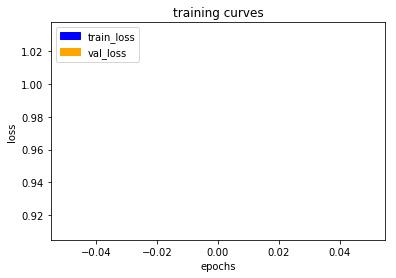

57/57 [==============================] - 208s - loss: 1.0307 - val_loss: 0.9109
Epoch 2/70
56/57 [============================>.] - ETA: 2s - loss: 0.7234

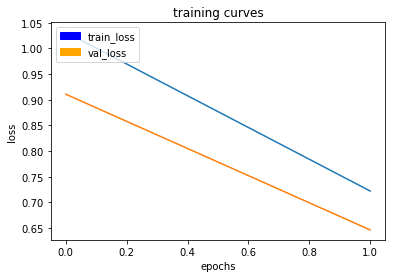

57/57 [==============================] - 202s - loss: 0.7213 - val_loss: 0.6463
Epoch 3/70
56/57 [============================>.] - ETA: 2s - loss: 0.4578

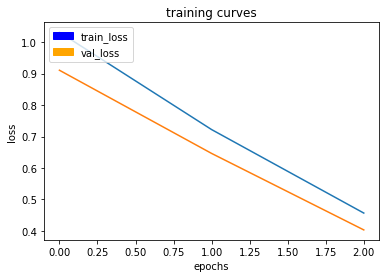

57/57 [==============================] - 201s - loss: 0.4559 - val_loss: 0.4030
Epoch 4/70
56/57 [============================>.] - ETA: 2s - loss: 0.2779

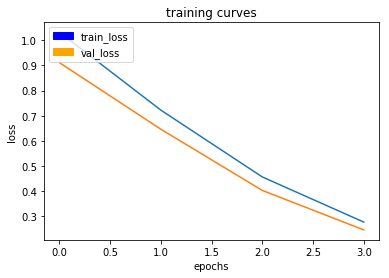

57/57 [==============================] - 201s - loss: 0.2768 - val_loss: 0.2461
Epoch 5/70
56/57 [============================>.] - ETA: 2s - loss: 0.1776

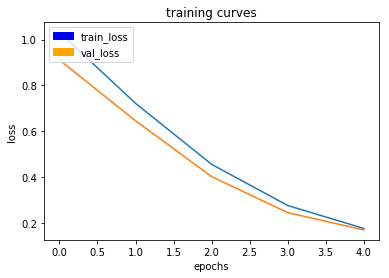

57/57 [==============================] - 202s - loss: 0.1770 - val_loss: 0.1709
Epoch 6/70
56/57 [============================>.] - ETA: 2s - loss: 0.1241

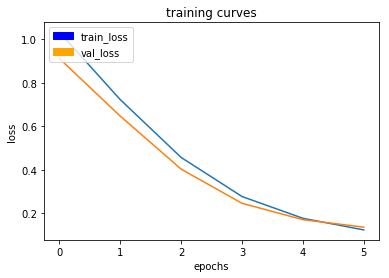

57/57 [==============================] - 201s - loss: 0.1237 - val_loss: 0.1366
Epoch 7/70
56/57 [============================>.] - ETA: 2s - loss: 0.0927

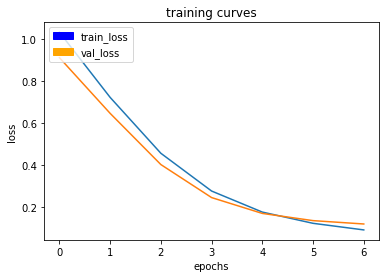

57/57 [==============================] - 202s - loss: 0.0924 - val_loss: 0.1207
Epoch 8/70
56/57 [============================>.] - ETA: 2s - loss: 0.0767

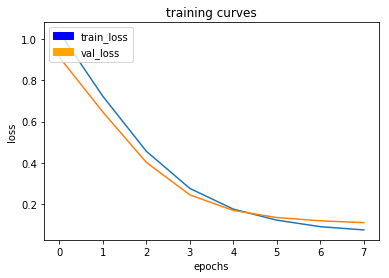

57/57 [==============================] - 202s - loss: 0.0769 - val_loss: 0.1120
Epoch 9/70
56/57 [============================>.] - ETA: 2s - loss: 0.0622

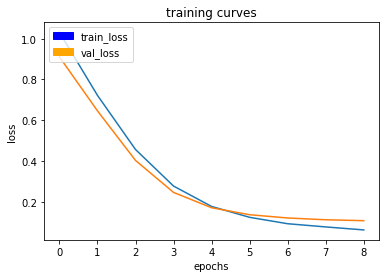

57/57 [==============================] - 202s - loss: 0.0621 - val_loss: 0.1074
Epoch 10/70
56/57 [============================>.] - ETA: 2s - loss: 0.0529

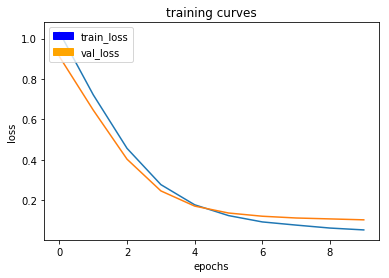

57/57 [==============================] - 202s - loss: 0.0530 - val_loss: 0.1029
Epoch 11/70
56/57 [============================>.] - ETA: 2s - loss: 0.0465

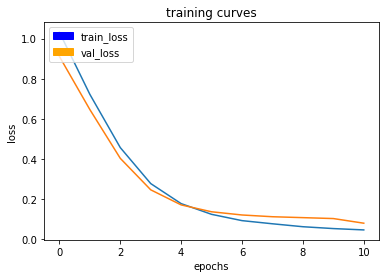

57/57 [==============================] - 202s - loss: 0.0464 - val_loss: 0.0797
Epoch 12/70
56/57 [============================>.] - ETA: 2s - loss: 0.0417

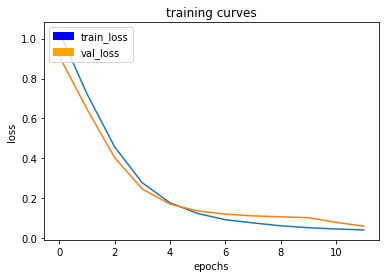

57/57 [==============================] - 202s - loss: 0.0416 - val_loss: 0.0604
Epoch 13/70
56/57 [============================>.] - ETA: 2s - loss: 0.0385

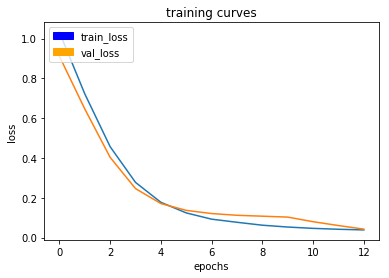

57/57 [==============================] - 201s - loss: 0.0385 - val_loss: 0.0424
Epoch 14/70
56/57 [============================>.] - ETA: 2s - loss: 0.0356

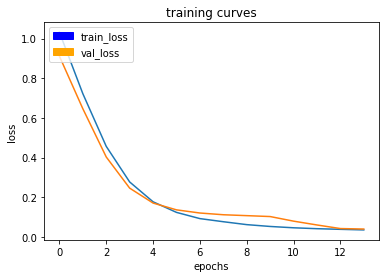

57/57 [==============================] - 201s - loss: 0.0355 - val_loss: 0.0400
Epoch 15/70
56/57 [============================>.] - ETA: 2s - loss: 0.0327

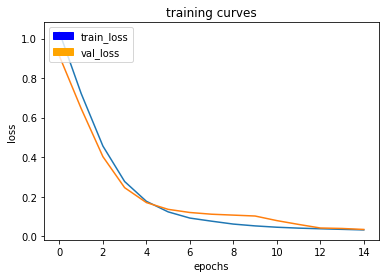

57/57 [==============================] - 202s - loss: 0.0326 - val_loss: 0.0350
Epoch 16/70
56/57 [============================>.] - ETA: 2s - loss: 0.0309

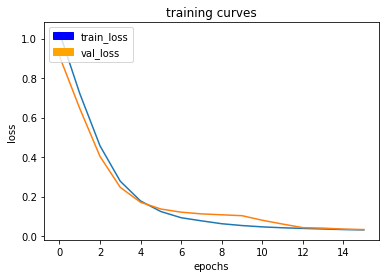

57/57 [==============================] - 201s - loss: 0.0308 - val_loss: 0.0327
Epoch 17/70
56/57 [============================>.] - ETA: 2s - loss: 0.0289

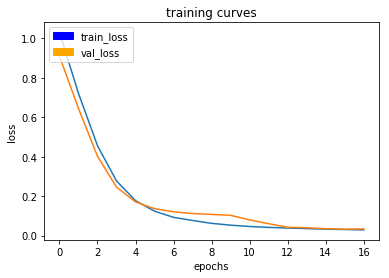

57/57 [==============================] - 201s - loss: 0.0289 - val_loss: 0.0340
Epoch 18/70
56/57 [============================>.] - ETA: 2s - loss: 0.0281

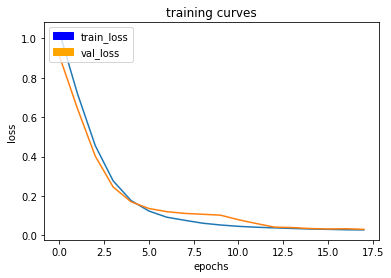

57/57 [==============================] - 202s - loss: 0.0280 - val_loss: 0.0309
Epoch 19/70
56/57 [============================>.] - ETA: 2s - loss: 0.0257

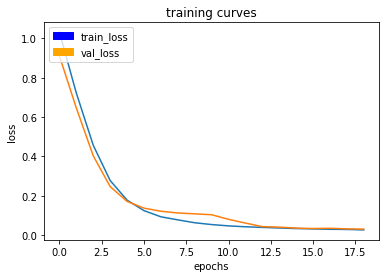

57/57 [==============================] - 201s - loss: 0.0257 - val_loss: 0.0298
Epoch 20/70
56/57 [============================>.] - ETA: 2s - loss: 0.0252

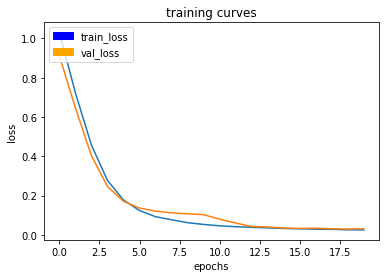

57/57 [==============================] - 202s - loss: 0.0252 - val_loss: 0.0312
Epoch 21/70
56/57 [============================>.] - ETA: 2s - loss: 0.0319

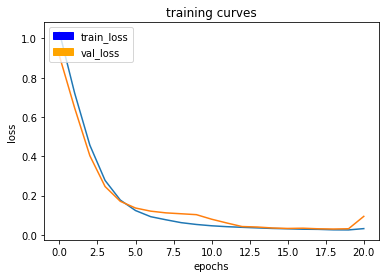

57/57 [==============================] - 201s - loss: 0.0318 - val_loss: 0.0942
Epoch 22/70
56/57 [============================>.] - ETA: 2s - loss: 0.0263

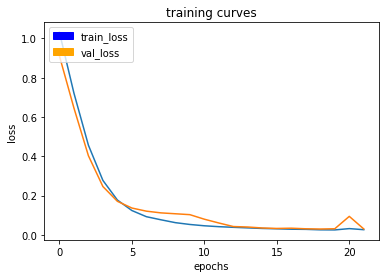

57/57 [==============================] - 201s - loss: 0.0263 - val_loss: 0.0300
Epoch 23/70
56/57 [============================>.] - ETA: 2s - loss: 0.0252

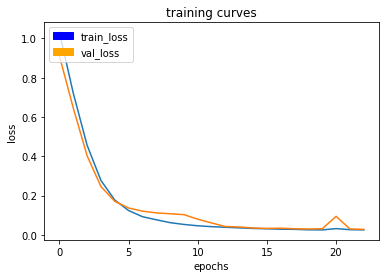

57/57 [==============================] - 202s - loss: 0.0251 - val_loss: 0.0280
Epoch 24/70
56/57 [============================>.] - ETA: 2s - loss: 0.0244

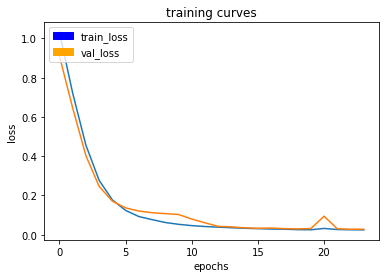

57/57 [==============================] - 202s - loss: 0.0243 - val_loss: 0.0280
Epoch 25/70
56/57 [============================>.] - ETA: 2s - loss: 0.0221

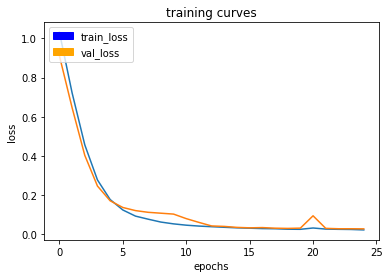

57/57 [==============================] - 201s - loss: 0.0221 - val_loss: 0.0275
Epoch 26/70
56/57 [============================>.] - ETA: 2s - loss: 0.0214

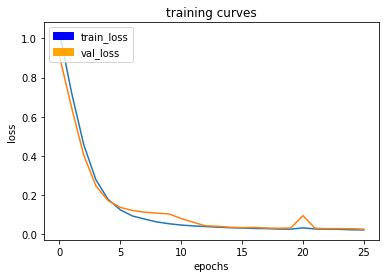

57/57 [==============================] - 201s - loss: 0.0214 - val_loss: 0.0252
Epoch 27/70
56/57 [============================>.] - ETA: 2s - loss: 0.0205

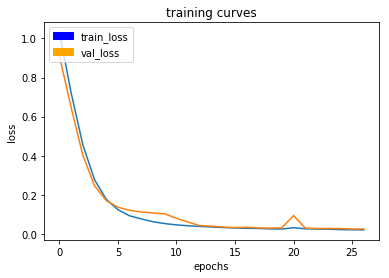

57/57 [==============================] - 202s - loss: 0.0205 - val_loss: 0.0254
Epoch 28/70
56/57 [============================>.] - ETA: 2s - loss: 0.0193

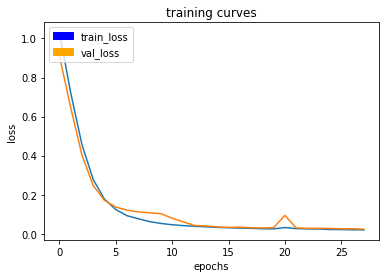

57/57 [==============================] - 201s - loss: 0.0201 - val_loss: 0.0239
Epoch 29/70
56/57 [============================>.] - ETA: 2s - loss: 0.0206

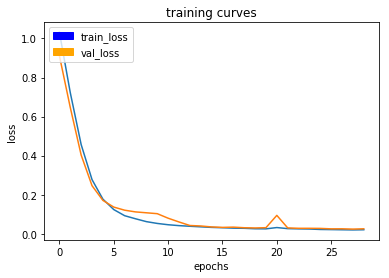

57/57 [==============================] - 202s - loss: 0.0206 - val_loss: 0.0255
Epoch 30/70
56/57 [============================>.] - ETA: 2s - loss: 0.0201

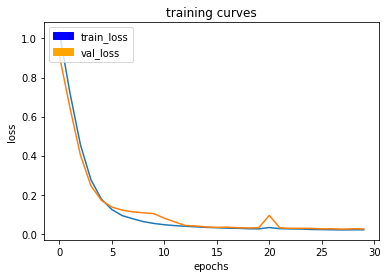

57/57 [==============================] - 201s - loss: 0.0200 - val_loss: 0.0248
Epoch 31/70
56/57 [============================>.] - ETA: 2s - loss: 0.0189

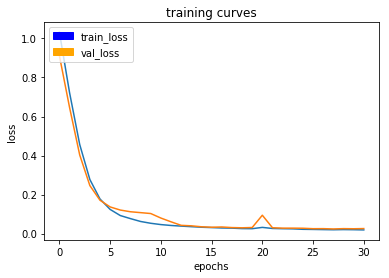

57/57 [==============================] - 201s - loss: 0.0189 - val_loss: 0.0258
Epoch 32/70
56/57 [============================>.] - ETA: 2s - loss: 0.0184

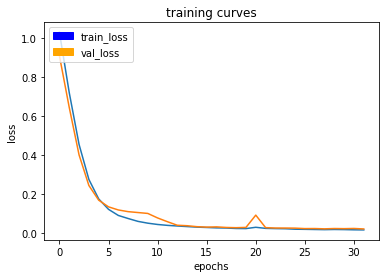

57/57 [==============================] - 202s - loss: 0.0184 - val_loss: 0.0233
Epoch 33/70
56/57 [============================>.] - ETA: 2s - loss: 0.0180

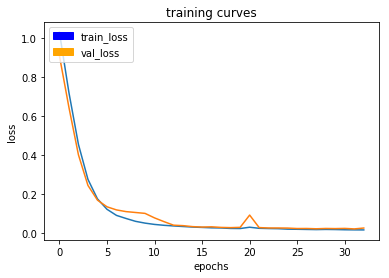

57/57 [==============================] - 202s - loss: 0.0181 - val_loss: 0.0277
Epoch 34/70
56/57 [============================>.] - ETA: 2s - loss: 0.0231

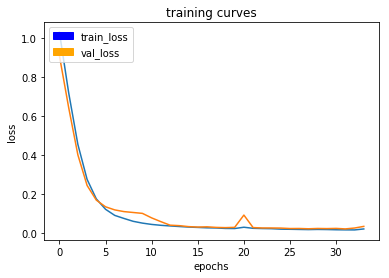

57/57 [==============================] - 201s - loss: 0.0230 - val_loss: 0.0362
Epoch 35/70
56/57 [============================>.] - ETA: 2s - loss: 0.0198

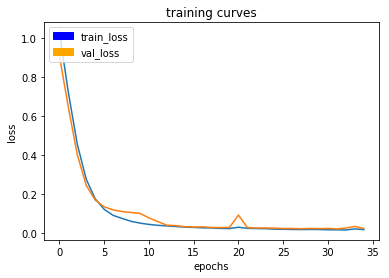

57/57 [==============================] - 201s - loss: 0.0198 - val_loss: 0.0254
Epoch 36/70
56/57 [============================>.] - ETA: 2s - loss: 0.0186

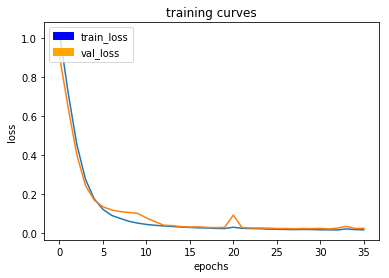

57/57 [==============================] - 202s - loss: 0.0186 - val_loss: 0.0267
Epoch 37/70
56/57 [============================>.] - ETA: 2s - loss: 0.0182

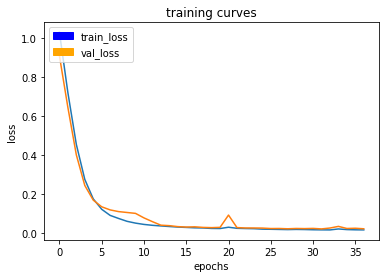

57/57 [==============================] - 201s - loss: 0.0182 - val_loss: 0.0239
Epoch 38/70
56/57 [============================>.] - ETA: 2s - loss: 0.0170

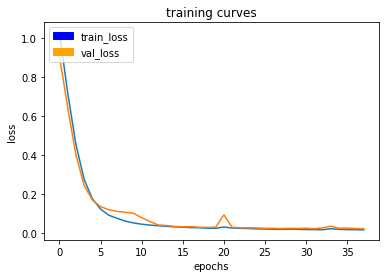

57/57 [==============================] - 201s - loss: 0.0170 - val_loss: 0.0234
Epoch 39/70
56/57 [============================>.] - ETA: 2s - loss: 0.0166

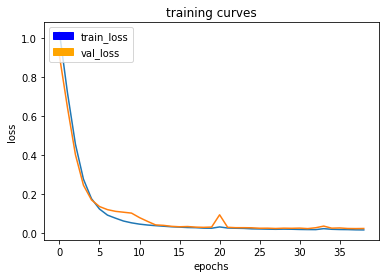

57/57 [==============================] - 202s - loss: 0.0165 - val_loss: 0.0239
Epoch 40/70
56/57 [============================>.] - ETA: 2s - loss: 0.0164

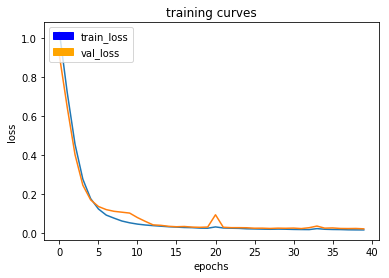

57/57 [==============================] - 201s - loss: 0.0164 - val_loss: 0.0220
Epoch 41/70
56/57 [============================>.] - ETA: 2s - loss: 0.0163

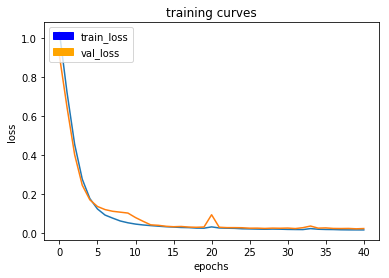

57/57 [==============================] - 202s - loss: 0.0163 - val_loss: 0.0233
Epoch 42/70
56/57 [============================>.] - ETA: 2s - loss: 0.0159

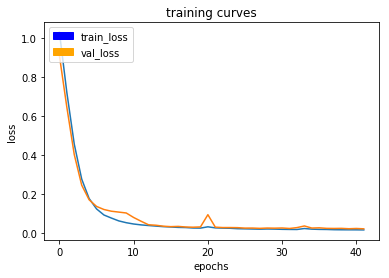

57/57 [==============================] - 201s - loss: 0.0159 - val_loss: 0.0215
Epoch 43/70
56/57 [============================>.] - ETA: 2s - loss: 0.0155

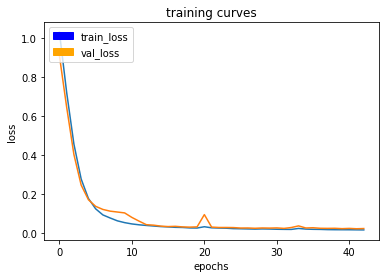

57/57 [==============================] - 202s - loss: 0.0155 - val_loss: 0.0225
Epoch 44/70
56/57 [============================>.] - ETA: 2s - loss: 0.0152

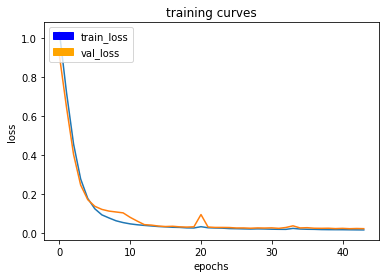

57/57 [==============================] - 201s - loss: 0.0152 - val_loss: 0.0217
Epoch 45/70
56/57 [============================>.] - ETA: 2s - loss: 0.0152

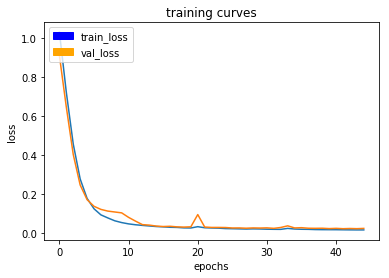

57/57 [==============================] - 202s - loss: 0.0152 - val_loss: 0.0230
Epoch 46/70
56/57 [============================>.] - ETA: 2s - loss: 0.0150

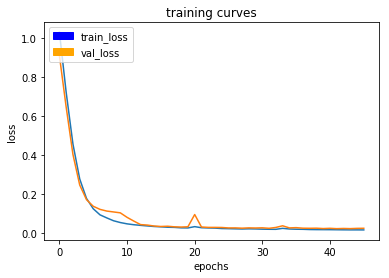

57/57 [==============================] - 201s - loss: 0.0150 - val_loss: 0.0234
Epoch 47/70
56/57 [============================>.] - ETA: 2s - loss: 0.0148

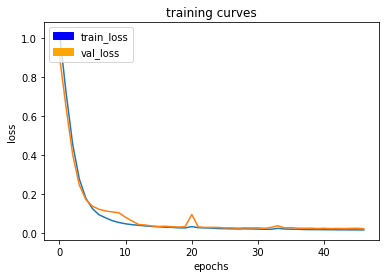

57/57 [==============================] - 201s - loss: 0.0148 - val_loss: 0.0213
Epoch 48/70
56/57 [============================>.] - ETA: 2s - loss: 0.0147

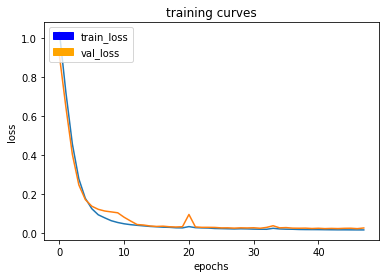

57/57 [==============================] - 202s - loss: 0.0148 - val_loss: 0.0248
Epoch 49/70
56/57 [============================>.] - ETA: 2s - loss: 0.0185

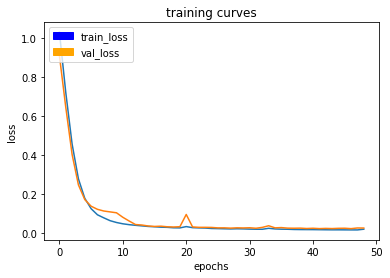

57/57 [==============================] - 201s - loss: 0.0184 - val_loss: 0.0244
Epoch 50/70
56/57 [============================>.] - ETA: 2s - loss: 0.0171

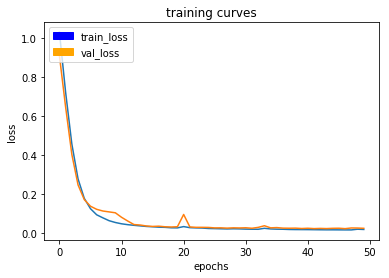

57/57 [==============================] - 202s - loss: 0.0171 - val_loss: 0.0230
Epoch 51/70
56/57 [============================>.] - ETA: 2s - loss: 0.0155

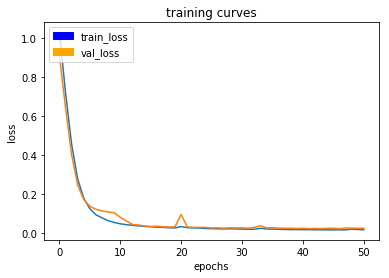

57/57 [==============================] - 201s - loss: 0.0155 - val_loss: 0.0236
Epoch 52/70
56/57 [============================>.] - ETA: 2s - loss: 0.0159

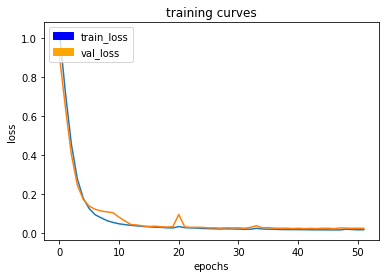

57/57 [==============================] - 201s - loss: 0.0159 - val_loss: 0.0232
Epoch 53/70
56/57 [============================>.] - ETA: 2s - loss: 0.0152

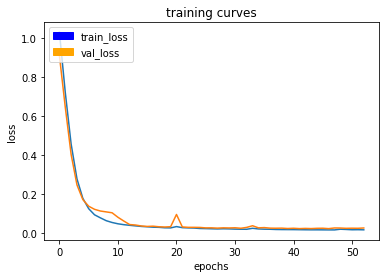

57/57 [==============================] - 201s - loss: 0.0152 - val_loss: 0.0247
Epoch 54/70
56/57 [============================>.] - ETA: 2s - loss: 0.0155

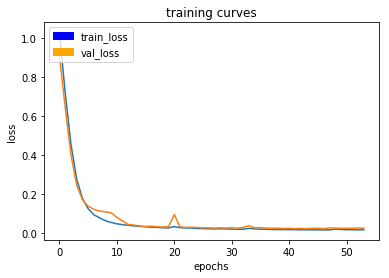

57/57 [==============================] - 202s - loss: 0.0156 - val_loss: 0.0235
Epoch 55/70
56/57 [============================>.] - ETA: 2s - loss: 0.0156

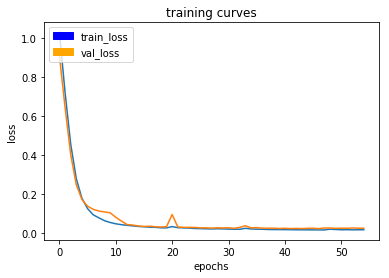

57/57 [==============================] - 201s - loss: 0.0156 - val_loss: 0.0235
Epoch 56/70
56/57 [============================>.] - ETA: 2s - loss: 0.0146

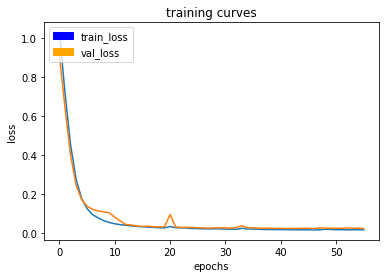

57/57 [==============================] - 202s - loss: 0.0146 - val_loss: 0.0217
Epoch 57/70
56/57 [============================>.] - ETA: 2s - loss: 0.0145

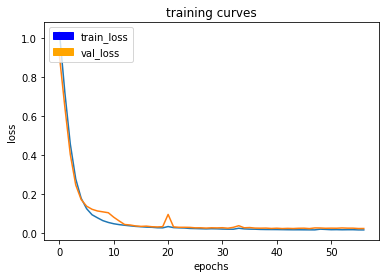

57/57 [==============================] - 201s - loss: 0.0145 - val_loss: 0.0218
Epoch 58/70
56/57 [============================>.] - ETA: 2s - loss: 0.0144

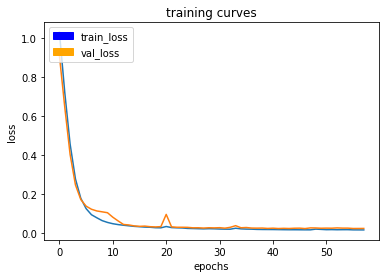

57/57 [==============================] - 202s - loss: 0.0143 - val_loss: 0.0219
Epoch 59/70
56/57 [============================>.] - ETA: 2s - loss: 0.0140

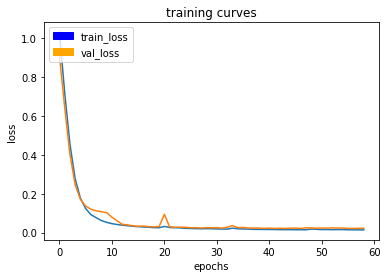

57/57 [==============================] - 201s - loss: 0.0139 - val_loss: 0.0226
Epoch 60/70
56/57 [============================>.] - ETA: 2s - loss: 0.0137

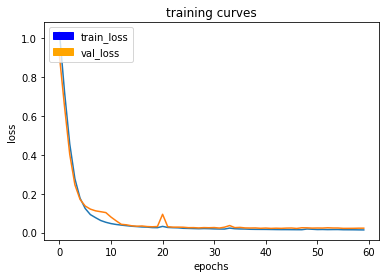

57/57 [==============================] - 201s - loss: 0.0137 - val_loss: 0.0226
Epoch 61/70
56/57 [============================>.] - ETA: 2s - loss: 0.0135

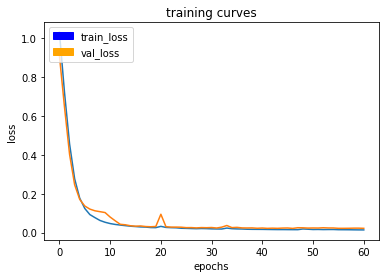

57/57 [==============================] - 201s - loss: 0.0135 - val_loss: 0.0217
Epoch 62/70
56/57 [============================>.] - ETA: 2s - loss: 0.0133

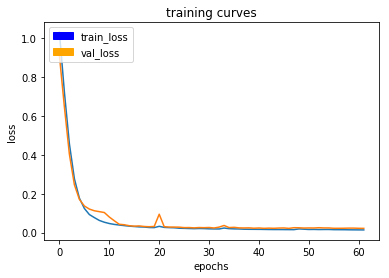

57/57 [==============================] - 202s - loss: 0.0133 - val_loss: 0.0213
Epoch 63/70
56/57 [============================>.] - ETA: 2s - loss: 0.0133

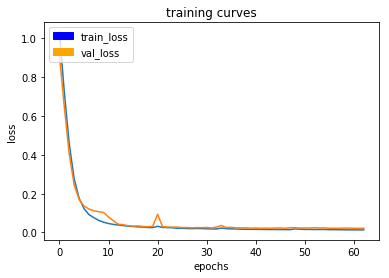

57/57 [==============================] - 201s - loss: 0.0133 - val_loss: 0.0217
Epoch 64/70
56/57 [============================>.] - ETA: 2s - loss: 0.0135

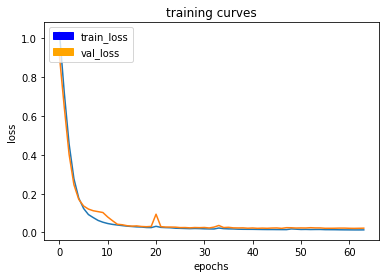

57/57 [==============================] - 201s - loss: 0.0135 - val_loss: 0.0222
Epoch 65/70
56/57 [============================>.] - ETA: 2s - loss: 0.0133

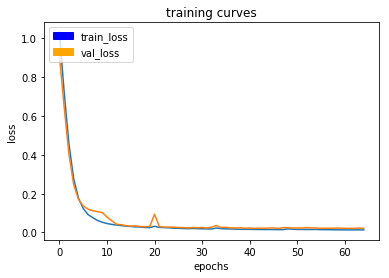

57/57 [==============================] - 202s - loss: 0.0133 - val_loss: 0.0217
Epoch 66/70
56/57 [============================>.] - ETA: 2s - loss: 0.0130

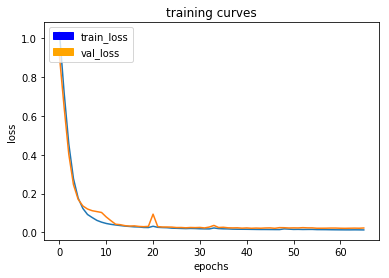

57/57 [==============================] - 201s - loss: 0.0130 - val_loss: 0.0229
Epoch 67/70
56/57 [============================>.] - ETA: 2s - loss: 0.0130

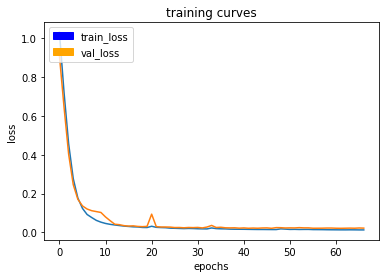

57/57 [==============================] - 203s - loss: 0.0130 - val_loss: 0.0221
Epoch 68/70
56/57 [============================>.] - ETA: 2s - loss: 0.0130

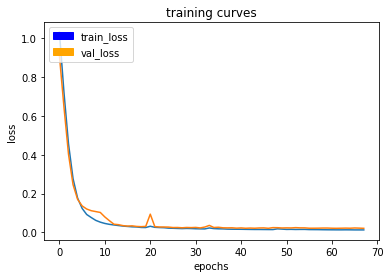

57/57 [==============================] - 202s - loss: 0.0129 - val_loss: 0.0212
Epoch 69/70
56/57 [============================>.] - ETA: 2s - loss: 0.0131

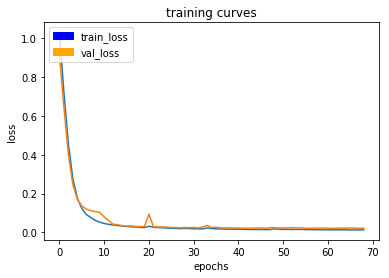

57/57 [==============================] - 202s - loss: 0.0131 - val_loss: 0.0219
Epoch 70/70
56/57 [============================>.] - ETA: 2s - loss: 0.0128

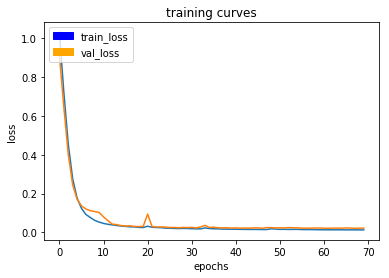

57/57 [==============================] - 201s - loss: 0.0127 - val_loss: 0.0219


In [65]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

Epoch 71/80
56/57 [============================>.] - ETA: 2s - loss: 0.0127

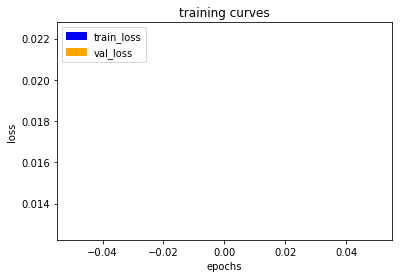

57/57 [==============================] - 208s - loss: 0.0127 - val_loss: 0.0223
Epoch 72/80
56/57 [============================>.] - ETA: 2s - loss: 0.0126

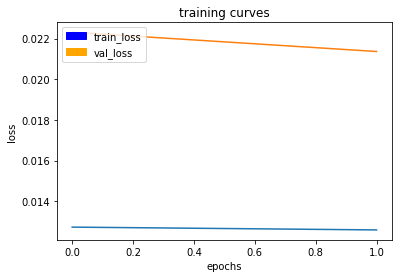

57/57 [==============================] - 202s - loss: 0.0126 - val_loss: 0.0214
Epoch 73/80
56/57 [============================>.] - ETA: 2s - loss: 0.0125

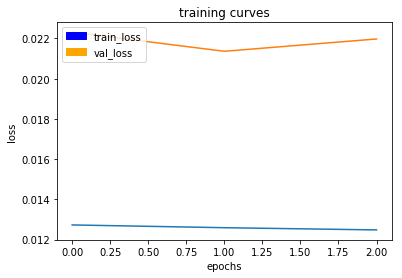

57/57 [==============================] - 202s - loss: 0.0125 - val_loss: 0.0220
Epoch 74/80
56/57 [============================>.] - ETA: 2s - loss: 0.0124

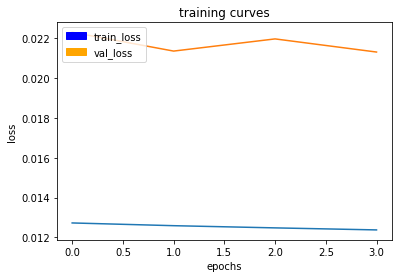

57/57 [==============================] - 202s - loss: 0.0124 - val_loss: 0.0213
Epoch 75/80
56/57 [============================>.] - ETA: 2s - loss: 0.0124

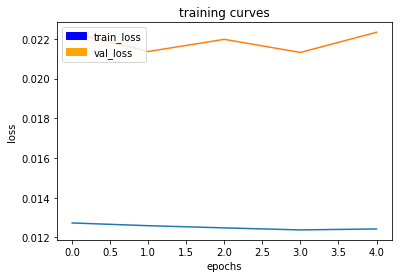

57/57 [==============================] - 203s - loss: 0.0124 - val_loss: 0.0223
Epoch 76/80
56/57 [============================>.] - ETA: 2s - loss: 0.0122

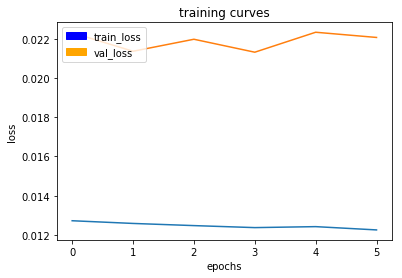

57/57 [==============================] - 202s - loss: 0.0123 - val_loss: 0.0221
Epoch 77/80
56/57 [============================>.] - ETA: 2s - loss: 0.0123

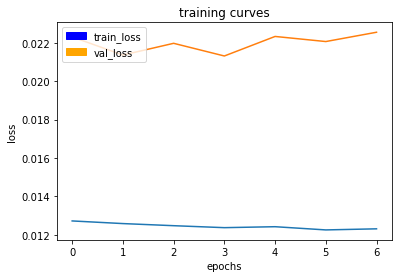

57/57 [==============================] - 203s - loss: 0.0123 - val_loss: 0.0226
Epoch 78/80
56/57 [============================>.] - ETA: 2s - loss: 0.0122

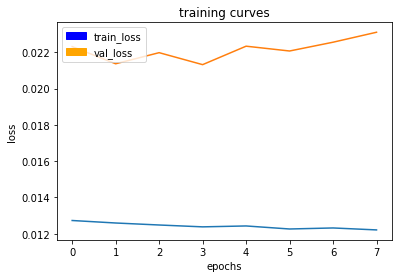

57/57 [==============================] - 202s - loss: 0.0122 - val_loss: 0.0231
Epoch 79/80
56/57 [============================>.] - ETA: 2s - loss: 0.0122

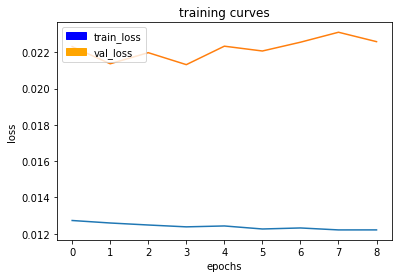

57/57 [==============================] - 202s - loss: 0.0122 - val_loss: 0.0226
Epoch 80/80
56/57 [============================>.] - ETA: 2s - loss: 0.0121

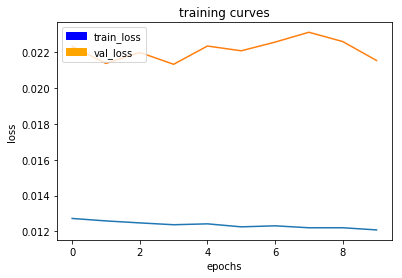

57/57 [==============================] - 202s - loss: 0.0121 - val_loss: 0.0215


In [15]:
model = restored_model
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

model.compile(optimizer=keras.optimizers.Adam(0.00015), loss='categorical_crossentropy')
logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]
model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = 80,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers,
                    initial_epoch=70,
)

In [16]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [5]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.
weight_file_name = 'model_weights'
restored_model = model_tools.load_network(weight_file_name)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 160, 160, 3)       0         
_________________________________________________________________
separable_conv2d_keras_25 (S (None, 80, 80, 64)        283       
_________________________________________________________________
batch_normalization_27 (Batc (None, 80, 80, 64)        256       
_________________________________________________________________
separable_conv2d_keras_26 (S (None, 40, 40, 128)       8896      
_________________________________________________________________
batch_normalization_28 (Batc (None, 40, 40, 128)       512       
_________________________________________________________________
separable_conv2d_keras_27 (S (None, 20, 20, 256)       34176     
_________________________________________________________________
batch_normalization_29 (Batc (None, 20, 20, 256)       1024      
__________

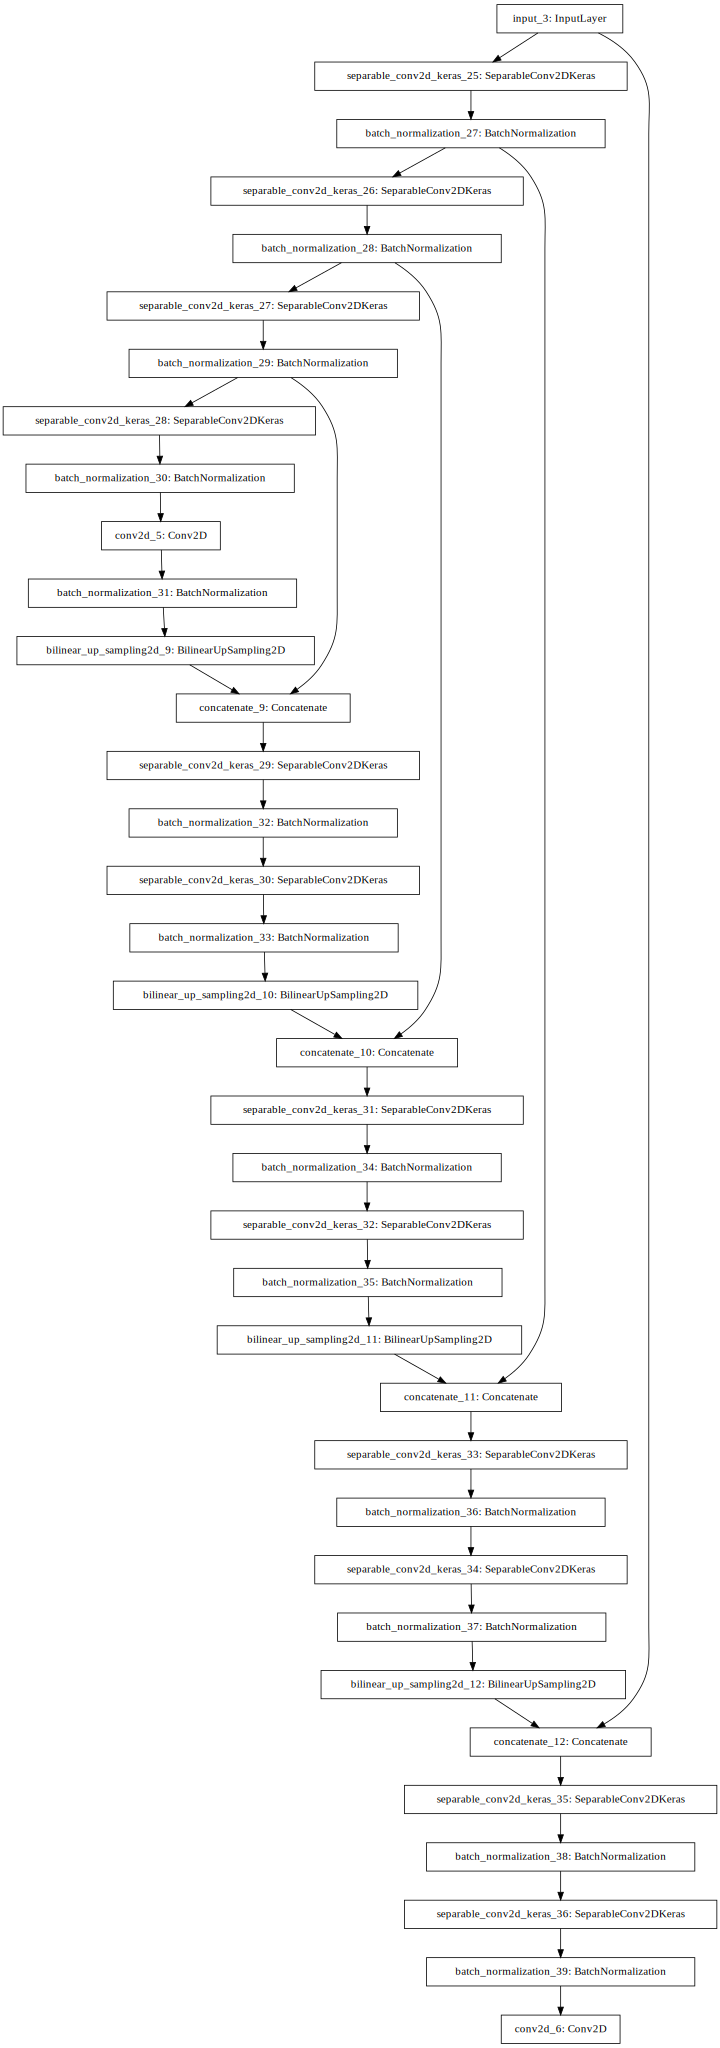

In [13]:
# Run to display the model
from IPython.display import SVG
from tensorflow.contrib.keras.python.keras.utils import plot_model
from tensorflow.contrib.keras.python.keras.utils.vis_utils import model_to_dot

restored_model.summary()
plot_model(restored_model, to_file='model.png', show_shapes=True)
SVG(model_to_dot(restored_model).create(prog='dot', format='svg'))

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [18]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

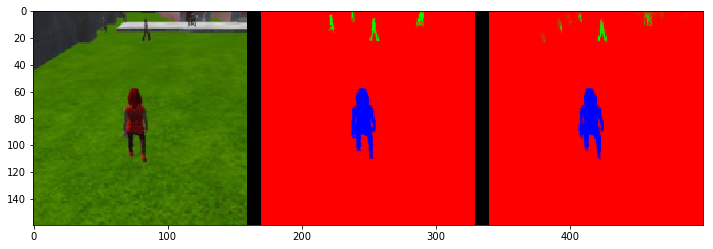

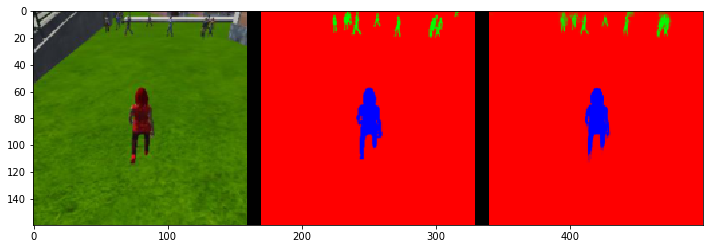

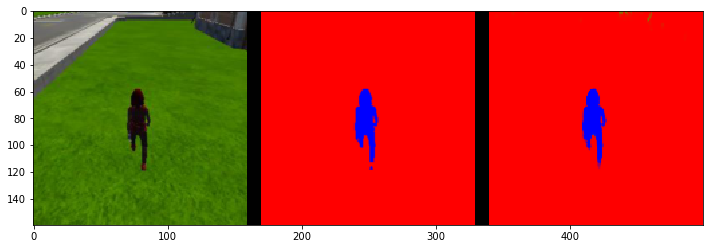

In [19]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

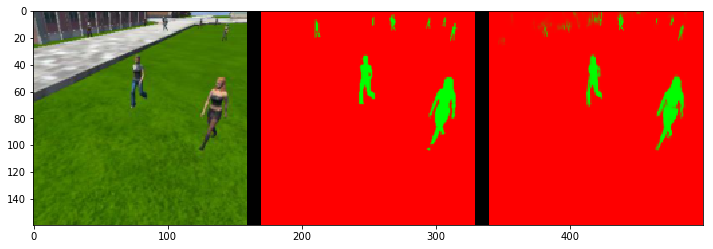

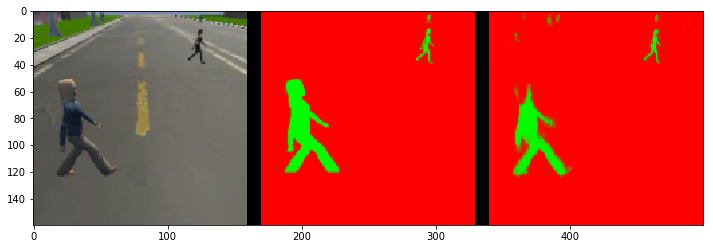

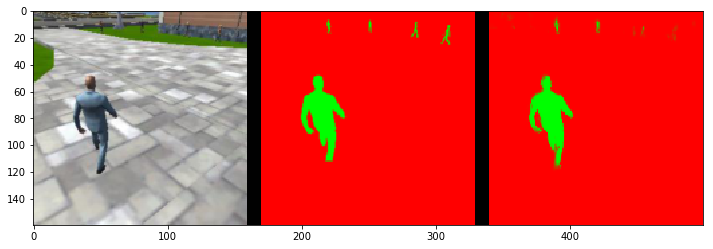

In [20]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

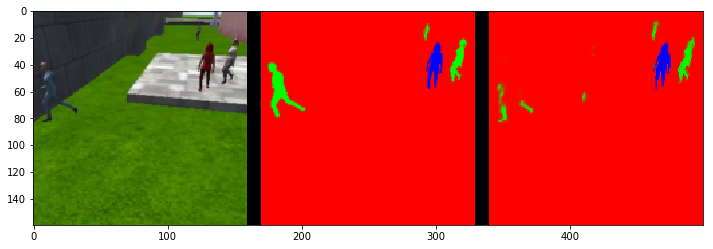

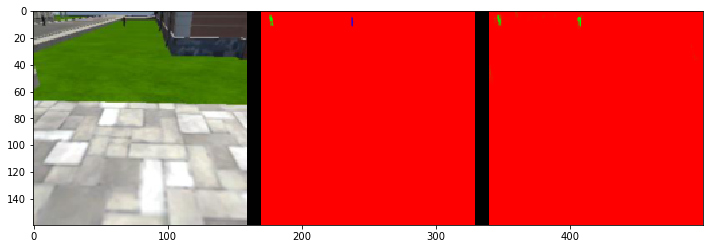

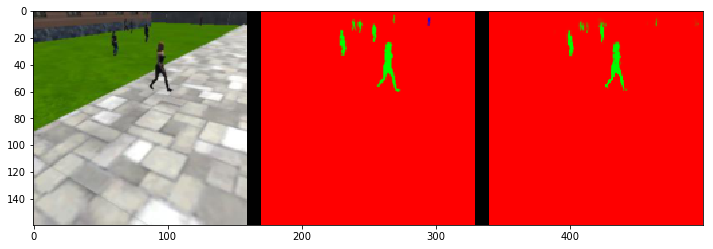

In [21]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [22]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9962776042691446
average intersection over union for other people is 0.383346667527765
average intersection over union for the hero is 0.9200759268289602
number true positives: 539, number false positives: 0, number false negatives: 0


In [23]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9903743098169467
average intersection over union for other people is 0.799188786554657
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 40, number false negatives: 0


In [24]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9970008432494347
average intersection over union for other people is 0.46497820047106303
average intersection over union for the hero is 0.22018435279064733
number true positives: 125, number false positives: 0, number false negatives: 176


In [25]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.7545454545454545


In [26]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.57013013981


In [27]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.430189105493
